In [1]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

#### Extracting pixels from images

In [2]:
directory = "homer_bart_1"
files = [os.path.join(directory,f) for f in sorted(os.listdir(directory)) if f!=".DS_Store"]
files[:5]

['homer_bart_1/bart1.bmp',
 'homer_bart_1/bart10.bmp',
 'homer_bart_1/bart100.bmp',
 'homer_bart_1/bart101.bmp',
 'homer_bart_1/bart102.bmp']

In [3]:
height,width = 128,128

In [4]:
images = []
classes = []
for image_path in files:
    image = cv2.imread(image_path)
    (H,W) = image.shape[:2]
    image = cv2.resize(image,(width,height))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = image.ravel()
    images.append(image)
    if "bart" in image_path.split("/")[1]:
        class_name = 0
    else:
        class_name = 1
    classes.append(class_name)
len(classes),len(images)

(269, 269)

In [5]:
X = np.asarray(images)
y = np.asarray(classes)

In [6]:
X.shape,y.shape

((269, 16384), (269,))

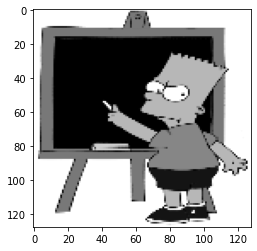

In [7]:
sample = X[1].reshape(width,height)
plt.imshow(sample,cmap='gray');

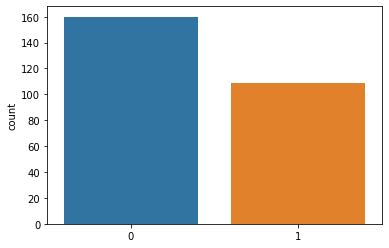

In [8]:
sns.countplot(y);

In [9]:
np.unique(y,return_counts=True)

(array([0, 1]), array([160, 109]))

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 16384 -> 8193 -> 8193 -> 1
model1 = Sequential()
model1.add(Dense(input_shape=(16384,),units=2000,activation="relu"))
model1.add(Dense(units=1000,activation="relu"))
model1.add(Dense(units=1,activation = "sigmoid"))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              32770000  
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 34,772,001
Trainable params: 34,772,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
model1.compile(optimizer="Adam",
               loss="binary_crossentropy",
               metrics=["accuracy"])

In [14]:
history = model1.fit(X_train,y_train,epochs=50)

Epoch 1/50
7/7 [==============================] - 1s 88ms/step - loss: 25.6840 - accuracy: 0.4698
Epoch 2/50
7/7 [==============================] - 1s 89ms/step - loss: 8.5699 - accuracy: 0.5860
Epoch 3/50
7/7 [==============================] - 1s 90ms/step - loss: 9.4342 - accuracy: 0.5349
Epoch 4/50
7/7 [==============================] - 1s 89ms/step - loss: 3.2357 - accuracy: 0.5907
Epoch 5/50
7/7 [==============================] - 1s 89ms/step - loss: 1.0619 - accuracy: 0.5860
Epoch 6/50
7/7 [==============================] - 1s 90ms/step - loss: 0.7476 - accuracy: 0.5349
Epoch 7/50
7/7 [==============================] - 1s 91ms/step - loss: 0.7443 - accuracy: 0.5442
Epoch 8/50
7/7 [==============================] - 1s 89ms/step - loss: 0.6566 - accuracy: 0.6279
Epoch 9/50
7/7 [==============================] - 1s 88ms/step - loss: 0.6076 - accuracy: 0.6837
Epoch 10/50
7/7 [==============================] - 1s 88ms/step - loss: 0.6302 - accuracy: 0.6558
Epoch 11/50
7/7 [===========

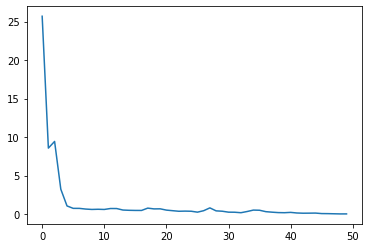

In [15]:
plt.plot(history.history["loss"]);

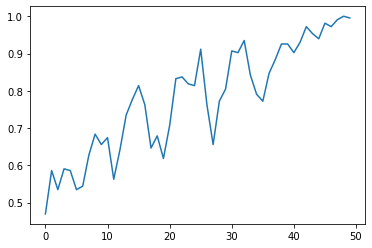

In [16]:
plt.plot(history.history["accuracy"]);

In [17]:
predictions = model1.predict(X_test)
predictions[:3]

array([[0.0101532 ],
       [0.99476874],
       [0.01125842]], dtype=float32)

In [18]:
predictions = (predictions>0.5)
predictions[:3]

array([[False],
       [ True],
       [False]])

In [19]:
from sklearn.metrics import accuracy_score,confusion_matrix

accuracy_score(y_test,predictions)

0.7407407407407407

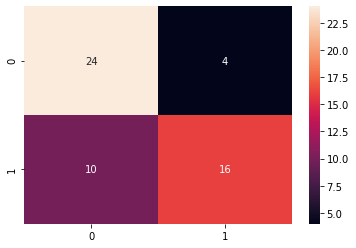

In [20]:
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True);

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.86      0.77        28
           1       0.80      0.62      0.70        26

    accuracy                           0.74        54
   macro avg       0.75      0.74      0.73        54
weighted avg       0.75      0.74      0.74        54



In [22]:
model1.predict(X_test[0].reshape(1,-1))

array([[0.0101532]], dtype=float32)

In [23]:
model_json = model1.to_json()
with open("models/model1.json","w") as json_file:
    json_file.write(model_json)

In [24]:
from tensorflow.keras.models import save_model

model1_saved = save_model(model1,"models/weights1.hdf5")

In [63]:
with open("models/model1.json") as json_file:
    json_loaded_model = json_file.read()

In [26]:
model1_loaded = tf.keras.models.model_from_json(json_loaded_model)
model1_loaded.load_weights("models/weights1.hdf5")
# model1_loaded.compile(optimizer="Adam",
#                       loss="binary_crossentropy",
#                       metrics=["accuracy"])
model1_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2000)              32770000  
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total params: 34,772,001
Trainable params: 34,772,001
Non-trainable params: 0
_________________________________________________________________


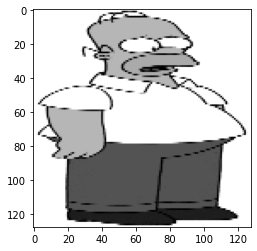

In [27]:
test_image = X_test[34]
plt.imshow(test_image.reshape(width,height),cmap="gray");

In [28]:
result = model1.predict(X_test[0].reshape(1,-1))
if result <0.5:
    print("Bart")
else:
    print("Homer")

Bart


#### Feature Extraction

In [64]:
files[:3]

['homer_bart_1/bart1.bmp',
 'homer_bart_1/bart10.bmp',
 'homer_bart_1/bart100.bmp']

In [55]:
export = f'mouth,pants,shoes,tshirt,shorts,sneakers,class\n'

In [56]:
show_images = False
features = []
for image_path in files:
    original_image = cv2.imread(image_path)
    (H,W) = original_image.shape[:2]
    image = original_image.copy()
    image_features = []
    mouth = pants = shoes = 0
    tshirt = sneakers = shorts = 0
    image_name = image_path.split("/")[1][:-4]
    
    if "bart" in image_name:
        class_name = 0  # Bart
    else:
        class_name = 1  # Homer
        
    for height in range(0,H):
        for width in range(0,W):
            blue = image.item(height,width,0)
            green = image.item(height,width,1)            
            red = image.item(height,width,2) 
            
            # Homer - brown mouth
            if blue >= 95 and blue <=140 and green >=160 and green <=185 and red >= 175 and red <=200:
                image[height,width] = [0,255,255]
                mouth += 1
            # Homer - blue pants
            if blue >= 150 and blue <=180 and green >=98 and green <=120 and red >= 0 and red <=90:
                image[height,width] = [0,255,255]
                pants += 1
            # Homer - gray shoes
            if height > (H/2):
                if blue >= 25 and blue <=45 and green >=25 and green <=45 and red >= 25 and red <=45:
                    image[height,width] = [0,255,255]
                    shoes += 1
                    
            # Bart - orange tshirt
            if blue >= 11 and blue <=180 and green >=85 and green <=105 and red >= 240 and red <=255:
                image[height,width] = [0,255,128]
                tshirt += 1
            # Bart - blue shorts
            if blue >= 125 and blue <=170 and green >=0 and green <=12 and red >= 0 and red <=20:
                image[height,width] = [0,255,128]
                shorts += 1
            # Bart - blue sneakers
            if height > (H/2):
                if blue >= 125 and blue <=170 and green >=0 and green <=12 and red >= 0 and red <=20:
                    image[height,width] = [0,255,128]
                    sneakers += 1

    mouth = round((mouth/(H*W))*100,9)
    pants = round((pants/(H*W))*100,9)
    shoes = round((shoes/(H*W))*100,9)
    tshirt = round((tshirt/(H*W))*100,9)
    shorts = round((shorts/(H*W))*100,9)
    sneakers = round((sneakers/(H*W))*100,9)
    
    image_features.append(mouth)
    image_features.append(pants)
    image_features.append(shoes)
    image_features.append(tshirt)
    image_features.append(shorts)
    image_features.append(sneakers)
    image_features.append(class_name)
    
    features.append(image_features)
    
    f = (",".join([str(item) for item in image_features]))
    export += f + "\n"
    
    if show_images:
        print(f"Homer mouth: {image_features[0]}")
        print(f"Homer pants: {image_features[1]}")
        print(f"Homer shoes: {image_features[2]}")
        print(f"Bart tshirt: {image_features[3]}")
        print(f"Bart shorts: {image_features[4]}")
        print(f"Bart sneakers: {image_features[5]}")
    
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        original_image = cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
        fig,ax = plt.subplots(1,2)
        ax[0].axis('off')
        ax[0].imshow(original_image)
        ax[1].axis('off')
        ax[1].imshow(image)
        plt.show()

In [57]:
with open("outputs/features.csv","w") as file:
    for l in export:
        file.write(l)
file.close()

In [104]:
data = pd.read_csv("outputs/features.csv")
data

,mouth,pants,shoes,tshirt,shorts,sneakers,class
0,0.000000,0.000000,0.114799,6.886102,3.495204,3.495204,0
1,0.000000,0.000000,0.110078,5.004901,3.183889,3.183889,0
2,0.000000,0.000000,0.182519,5.264620,5.029683,5.029683,0
3,0.000000,0.480168,0.080028,0.000000,0.000000,0.000000,0
4,0.000000,0.000000,0.029708,8.978929,3.459119,3.459119,0
...,...,...,...,...,...,...,...
264,6.485412,0.000000,0.171985,0.000000,0.000000,0.000000,1
265,0.000000,0.000000,0.161637,0.000000,0.000000,0.000000,1
266,4.264975,0.000000,0.329940,0.000000,0.000000,0.000000,1
267,1.429133,0.000000,0.034559,0.000000,0.000000,0.000000,1


In [105]:
X = data.drop("class",axis=1)
y = data[["class"]]

In [106]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 16384 -> 8193 -> 8193 -> 1
model2 = Sequential()
model2.add(Dense(input_shape=(6,),units=4,activation="relu"))
model2.add(Dense(units=4,activation="relu"))
model2.add(Dense(units=4,activation="relu"))
model2.add(Dense(units=1,activation = "sigmoid"))

model2.compile(optimizer="Adam",
               loss="binary_crossentropy",
               metrics=["accuracy"])

history = model2.fit(X_train,y_train,epochs=50)

Epoch 1/50
7/7 [==============================] - 0s 986us/step - loss: 0.7425 - accuracy: 0.4698
Epoch 2/50
7/7 [==============================] - 0s 940us/step - loss: 0.6998 - accuracy: 0.4930
Epoch 3/50
7/7 [==============================] - 0s 962us/step - loss: 0.6636 - accuracy: 0.5302
Epoch 4/50
7/7 [==============================] - 0s 1ms/step - loss: 0.6364 - accuracy: 0.5349
Epoch 5/50
7/7 [==============================] - 0s 1ms/step - loss: 0.6121 - accuracy: 0.5395
Epoch 6/50
7/7 [==============================] - 0s 2ms/step - loss: 0.5941 - accuracy: 0.5349
Epoch 7/50
7/7 [==============================] - 0s 1ms/step - loss: 0.5806 - accuracy: 0.5442
Epoch 8/50
7/7 [==============================] - 0s 1ms/step - loss: 0.5689 - accuracy: 0.5395
Epoch 9/50
7/7 [==============================] - 0s 1ms/step - loss: 0.5603 - accuracy: 0.5488
Epoch 10/50
7/7 [==============================] - 0s 1ms/step - loss: 0.5520 - accuracy: 0.6186
Epoch 11/50
7/7 [================

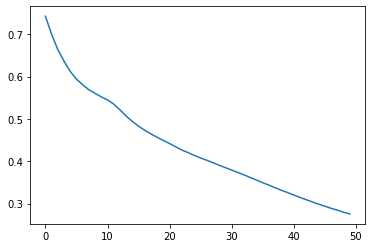

In [108]:
plt.plot(history.history["loss"]);

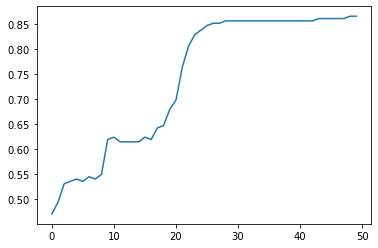

In [109]:
plt.plot(history.history["accuracy"]);

In [115]:
predictions = model2.predict(X_test)
predictions = predictions>0.5

In [116]:
accuracy_score(y_test,predictions)

0.9074074074074074

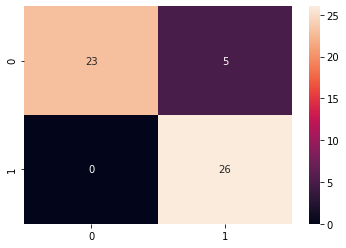

In [117]:
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True);

In [118]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        28
           1       0.84      1.00      0.91        26

    accuracy                           0.91        54
   macro avg       0.92      0.91      0.91        54
weighted avg       0.92      0.91      0.91        54



In [119]:
model2.predict(X_test.head(2))

array([[5.0607324e-04],
       [7.4122941e-01]], dtype=float32)

In [127]:
model_json = model2.to_json()
with open("models/model2.json","w") as json_file:
    json_file.write(model_json)
model2_saved = save_model(model2,"models/weights2.hdf5")

In [128]:
with open("models/model2.json") as json_file:
    json_loaded_model = json_file.read()
model2_loaded = tf.keras.models.model_from_json(json_loaded_model)
model2_loaded.load_weights("models/weights2.hdf5")
model2_loaded.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 4)                 28        
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [160]:
"Homer" if model2_loaded.predict(X_test.head(5))[0][0]>0.5 else "Bart"

'Bart'